In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
from shapely.geometry import Point

from osrmareas.downloader import GetPBF
from osrmareas.osrm import Server
from osrmareas import areas


download = GetPBF()

pbf_path = 'testing'
pbf_file = 'peru-latest.osm'

download.country(['peru']).get(save_dir=pbf_path)
peru = Server(pbf_file, pbf_path).run_all()

Convert the country names to lowercase and replace spaces with dashes (-).
source: https://download.geofabrik.de/
Found testing\peru-latest.osrm file. You can force with `force=True`
An HSGR file named 'testing\peru-latest.osrm.hsgr' was found. You can force with `force=True`
The server is running in the background, you can start making queries.


# Data

In [12]:
data_d = {
    "lat_ori": [-7.15741, -7.15741, -7.15741, -7.148193, -7.148193, -7.148193],
    "long_ori": [-78.464291, -78.464291, -78.464291, -78.45364, -78.45364, -78.45364],
    "lat_des": [-7.163929, -7.158723, -7.167424, -7.147372, -7.150449, -7.148007],
    "long_des": [
        -78.464291,
        -78.460384,
        -78.469067,
        -78.457773,
        -78.449846,
        -78.451314,
    ],
}
df = pd.DataFrame(data_d)
df

,lat_ori,long_ori,lat_des,long_des
0,-7.157410,-78.464291,-7.163929,-78.464291
1,-7.157410,-78.464291,-7.158723,-78.460384
2,-7.157410,-78.464291,-7.167424,-78.469067
3,-7.148193,-78.453640,-7.147372,-78.457773
4,-7.148193,-78.453640,-7.150449,-78.449846
5,-7.148193,-78.453640,-7.148007,-78.451314


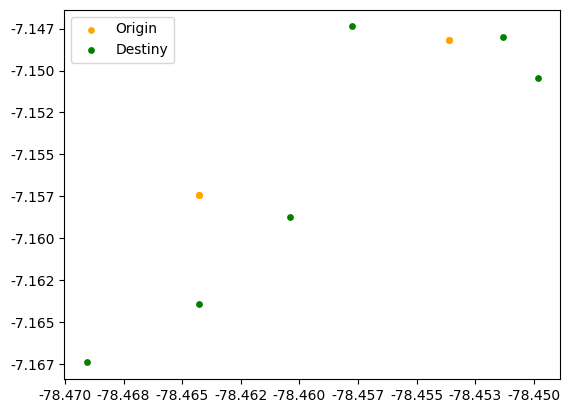

In [13]:

fig, ax = plt.subplots()

scatter_ori = ax.scatter(df['long_ori'], df['lat_ori'], c='orange', s=15, label='Origin')

scatter_des = ax.scatter(df['long_des'], df['lat_des'], c='green', s=15, label='Destiny')

def format_2digits(x, p):
    return '{:.3f}'.format(x)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_2digits))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_2digits))

ax.legend()

plt.show();


# OSRM

## Extract information (Test)

In [14]:
col_main = ['dist_driving_km', 'time_driving_sec', 'dist_eucl_km', 'geometry']

In [15]:
test = df.iloc[0]
from_ = [test['lat_ori'], test['long_ori']]
to_ = [test['lat_des'], test['long_des']]
route1 = areas.get_osrm_route(
	from_, to_
)

<Axes: >

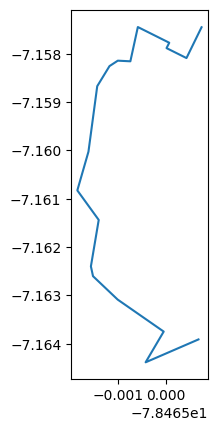

In [16]:
route1.plot()

In [17]:
values = route1[col_main].to_numpy()[0]
values

array([1.3023, 157.6, 0.7209461886355335,
       <LINESTRING (-78.464 -7.157, -78.465 -7.158, -78.465 -7.158, -78.465 -7.158,...>],
      dtype=object)

## Apply into dataFrame

In [18]:
def get_info(lat_ori, long_ori, lat_des, long_des):
	from_ = [lat_ori, long_ori]
	to_ = [lat_des, long_des]
	route1 = areas.get_osrm_route(
		from_, to_
	)
	values = route1[col_main].to_numpy()[0]
	return pd.Series(values)
get_info(from_[0], from_[1], to_[0], to_[1])

0                                               1.3023
1                                                157.6
2                                             0.720946
3    LINESTRING (-78.464249 -7.157431, -78.464573 -...
dtype: object

In [19]:
df[col_main] = df.apply(
	lambda row: get_info(
		row['lat_ori'], row['long_ori'],
		row['lat_des'], row['long_des'],
	)
	, axis = 1
	)
df = gpd.GeoDataFrame(df)
df

,lat_ori,long_ori,lat_des,long_des,dist_driving_km,time_driving_sec,dist_eucl_km,geometry
0,-7.157410,-78.464291,-7.163929,-78.464291,1.3023,157.6,0.720946,"LINESTRING (-78.46425 -7.15743, -78.46457 -7.1..."
1,-7.157410,-78.464291,-7.158723,-78.460384,2.3175,235.4,0.455332,"LINESTRING (-78.46425 -7.15743, -78.46457 -7.1..."
2,-7.157410,-78.464291,-7.167424,-78.469067,1.8686,241.2,1.226693,"LINESTRING (-78.46425 -7.15743, -78.46457 -7.1..."
3,-7.148193,-78.453640,-7.147372,-78.457773,0.6919,112.0,0.465473,"LINESTRING (-78.45360 -7.14821, -78.45362 -7.1..."
4,-7.148193,-78.453640,-7.150449,-78.449846,1.4374,237.7,0.487728,"LINESTRING (-78.45360 -7.14821, -78.45379 -7.1..."
5,-7.148193,-78.453640,-7.148007,-78.451314,0.3218,44.6,0.257752,"LINESTRING (-78.45360 -7.14821, -78.45342 -7.1..."


In [20]:
origin = df[['lat_ori', 'long_ori']].drop_duplicates()

origin['geometry'] = origin.apply(lambda row: Point(row['long_ori'], row['lat_ori']), axis=1)

origin = gpd.GeoDataFrame(origin, geometry='geometry')
destiny = df[['lat_des', 'long_des']]
destiny['geometry'] = destiny.apply(lambda row: Point(row['long_des'], row['lat_des']), axis=1)
destiny = gpd.GeoDataFrame(destiny, geometry='geometry')

## Result

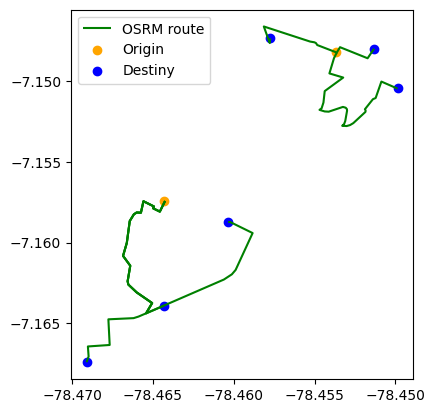

In [21]:
df.plot(ax = plt.gca(), color = 'green', label = 'OSRM route')
origin.plot(ax = plt.gca(), color = 'orange', label = 'Origin')
destiny.plot(ax = plt.gca(), color = 'blue', label = 'Destiny')
plt.legend()
plt.show()

# Minimum time

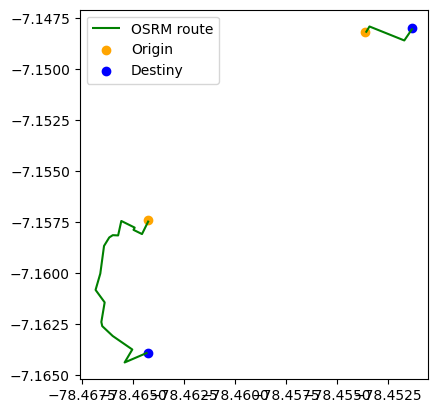

In [22]:
min_id = df.groupby(['lat_ori', 'long_ori'])['time_driving_sec'].idxmin()
min_time = df.iloc[min_id]
min_time.plot(ax = plt.gca(), color = 'green', label = 'OSRM route')
origin.plot(ax = plt.gca(), color = 'orange', label = 'Origin')
destiny.iloc[min_id].plot(ax = plt.gca(), color = 'blue', label = 'Destiny')
plt.legend()
plt.show()

In [23]:
min_time

,lat_ori,long_ori,lat_des,long_des,dist_driving_km,time_driving_sec,dist_eucl_km,geometry
0,-7.157410,-78.464291,-7.163929,-78.464291,1.3023,157.6,0.720946,"LINESTRING (-78.46425 -7.15743, -78.46457 -7.1..."
5,-7.148193,-78.453640,-7.148007,-78.451314,0.3218,44.6,0.257752,"LINESTRING (-78.45360 -7.14821, -78.45342 -7.1..."
